# Clustering the Physical Activities for a Subject in the "Highly Active" Group
Among the 183 subjects, we classified them into three categories based on their daily average steps:
* Inactive: daily average about 1 step.
* Moderately Active: daily average about 4 steps.
* Highly Active: daily average between 7-9 steps

In this notebook, we cluster the activities for a subject in the "High Active" category.

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9
import datetime as datetime
from dateutil.parser import parse

## Load and Parse the data into Time Series
The individual subjects data have been extracted and stored in a separated folder. This subject data is stored in a file "high1.csv".

In [265]:
dateparse = lambda d: parse(d)
df = pd.read_csv("patients_data/analyses/high1.csv", parse_dates = \
                 ['Datetime'], index_col = "Datetime", date_parser=dateparse)

### What are the unique dates in this subject's timeline? 

In [266]:
np.unique(df.index.date)

array([datetime.date(2016, 3, 29), datetime.date(2016, 3, 30),
       datetime.date(2016, 3, 31), datetime.date(2016, 4, 1),
       datetime.date(2016, 4, 2), datetime.date(2016, 4, 3),
       datetime.date(2016, 4, 4), datetime.date(2016, 4, 5),
       datetime.date(2016, 4, 6), datetime.date(2016, 4, 7),
       datetime.date(2016, 4, 8), datetime.date(2016, 4, 9),
       datetime.date(2016, 4, 10), datetime.date(2016, 4, 11),
       datetime.date(2016, 4, 12), datetime.date(2016, 4, 13),
       datetime.date(2016, 4, 14), datetime.date(2016, 4, 15),
       datetime.date(2016, 4, 16), datetime.date(2016, 4, 17),
       datetime.date(2016, 4, 18), datetime.date(2016, 4, 19),
       datetime.date(2016, 4, 20), datetime.date(2016, 4, 21)],
      dtype=object)

### What is the earlist time and latest time in the timeline?

In [267]:
print(np.min(df.index))
print ('-' * 10)
print(np.max(df.index))

2016-03-29 11:15:00
----------
2016-04-21 12:42:00


### How many records in total for this patient?

In [268]:
df = df.iloc[:, 2:]
df.shape

(33205, 15)

### In terms of steps, how do the average activities change in a day (0:00-23:00)?

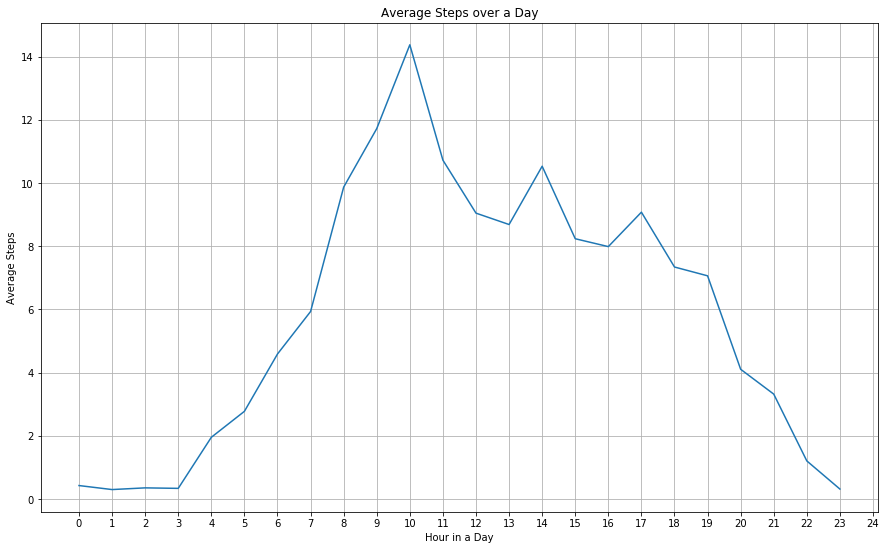

In [269]:
by_time = df[['Steps', 'Hour']].groupby('Hour').mean()
plt.plot(by_time)
plt.title("Average Steps over a Day")
plt.xticks(np.arange(25))
plt.xlabel("Hour in a Day")
plt.ylabel("Average Steps")
plt.grid()

### How do the activity patterns look like in terms of weekdays?

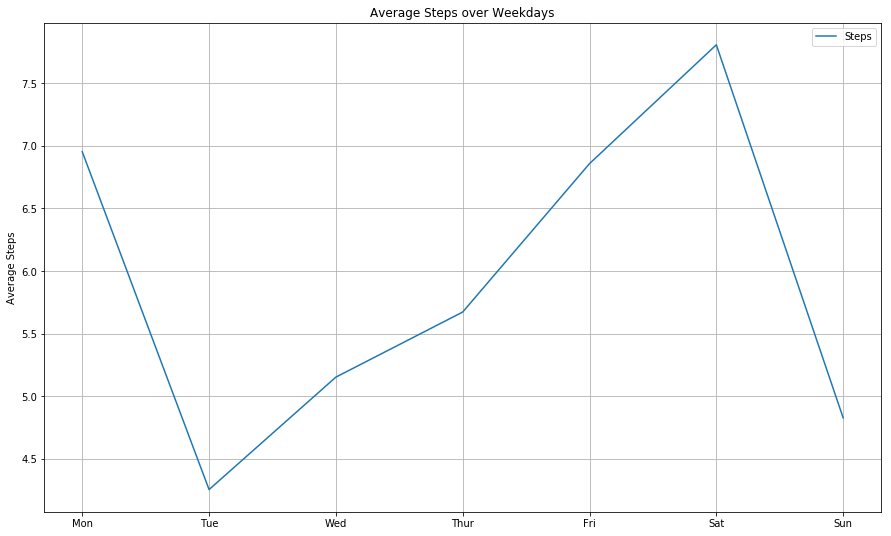

In [270]:
by_weekday = df[['Steps']].groupby(df.index.dayofweek).mean()
xticks = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
by_weekday.index = xticks
by_weekday.plot()
plt.xticks([0,1,2,3,4,5,6], xticks)
plt.ylabel("Average Steps")
plt.title("Average Steps over Weekdays")
plt.grid()

### How do the activity patterns look like in weekdays and weekend?

In [273]:
weekend = np.where(df.index.weekday < 5, 'weekday', 'weekend')
by_time = df.groupby([weekend, 'Hour']).mean()

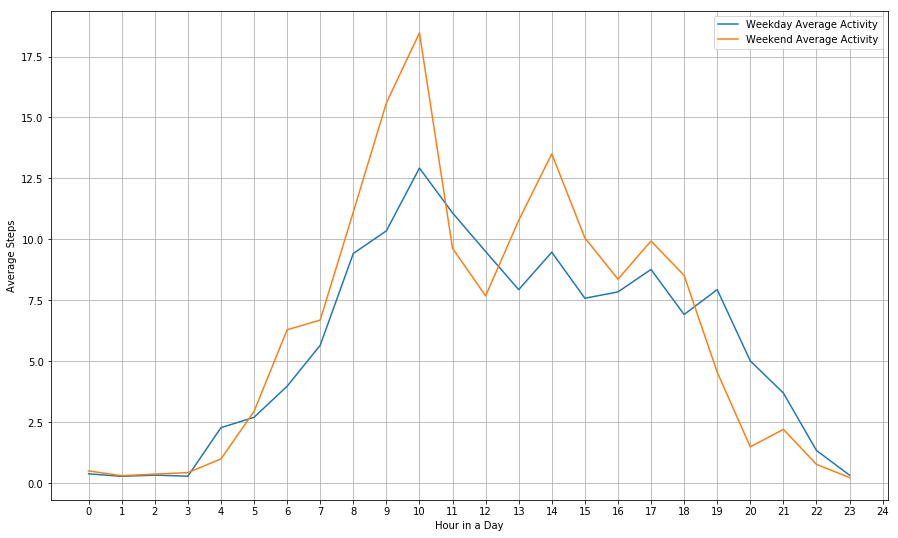

In [274]:
by_time.loc['weekday']['Steps'].plot(label = 'Weekday Average Activity')
by_time.loc['weekend']['Steps'].plot(label = "Weekend Average Activity")
plt.legend()
plt.xlabel("Hour in a Day")
plt.ylabel("Average Steps")
plt.xticks(np.arange(25))
plt.grid()

# Cluster the Activities by 15-minute means

In [275]:
df_15m = df.resample('15T').mean()
df_15m = df_15m[df_15m['WearSens'] == 1]

In [276]:
pd.set_option('display.max_rows', 20)

In [277]:
df_15m.reset_index(inplace = True)

In [278]:
df_15m_data = df_15m[['Steps', 'YCnt', 'XCnt', 'ZCnt', 'Calories', 'VMU', 'WearSens']]

In [279]:
df_15m_data.shape

(1792, 7)

In [280]:
df_15m_data.index

RangeIndex(start=0, stop=1792, step=1)

In [281]:
df_15m_data = df_15m_data[df_15m_data.WearSens == 1]

In [282]:
df_15m_data.shape

(1792, 7)

In [283]:
df_15m_data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791],
           dtype='int64', length=1792)

In [284]:
df_15m_data = df_15m_data.iloc[:, :-1]
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU
0,1.933333,377.066667,696.266667,339.266667,0.516635,879.113650
1,10.000000,1600.400000,1379.800000,2073.066667,2.740243,3001.597858
2,2.600000,638.666667,469.400000,759.200000,1.136949,1112.862831
3,4.800000,723.933333,650.000000,754.333333,1.066759,1275.988753
4,9.933333,1111.333333,1064.333333,1337.600000,1.948045,2087.919892


In [285]:
df_15m_data.shape

(1792, 6)

In [286]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [287]:
scaler = StandardScaler().fit(df_15m_data)
scaled = scaler.transform(df_15m_data)
scaled.mean(axis = 0)

array([-0., -0., -0.,  0.,  0.,  0.])

In [288]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [289]:
hclustering = linkage(scaled, 'ward')

### Cluster the 15-minute mean data into hierarchical clusters. The horizontal line cuts the hierarchical structure into 4 clusters. The numbers at bottom show the number of records in each cluster.

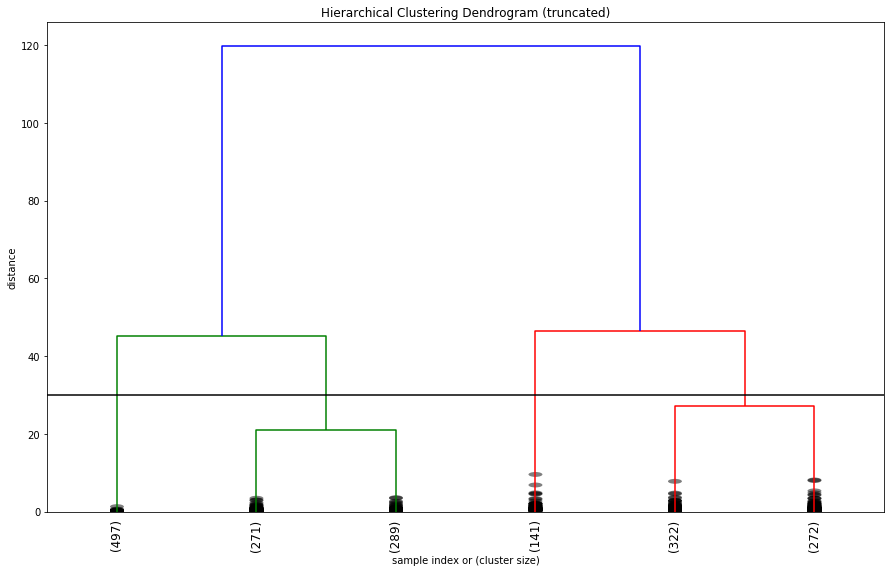

In [291]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    hclustering,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(30, c = 'k')
plt.show()

## Can we cluster the activities into Laying, Sitting, Standing, Walking?

# K-Means Clustering and Visualization

In [292]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

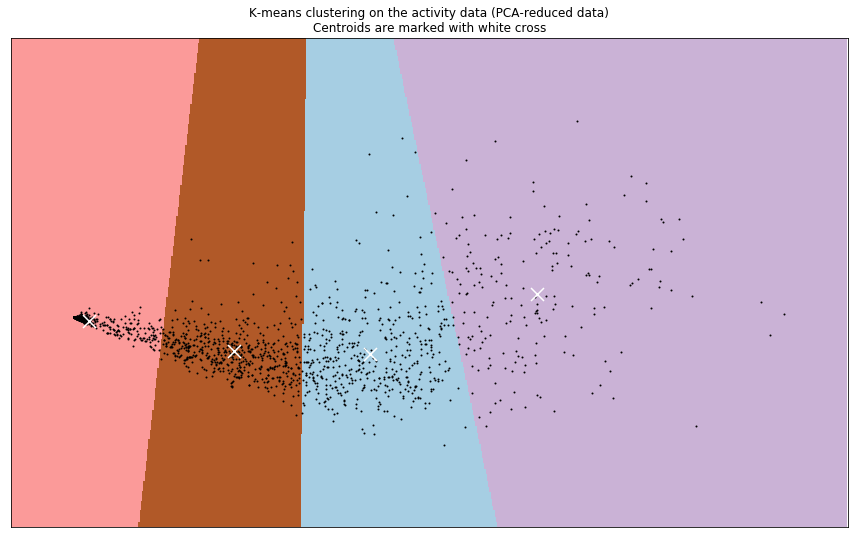

In [293]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(scaled)
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the activity data (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [294]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [295]:
kmeans.cluster_centers_

array([[-0.276, -0.103, -0.074, -0.042, -0.09 , -0.064],
       [ 2.168,  1.814,  1.794,  1.731,  1.755,  1.782],
       [ 0.509,  0.801,  0.798,  0.807,  0.859,  0.824],
       [-0.805, -1.053, -1.069, -1.084, -1.087, -1.092]])

In [296]:
pd.value_counts(kmeans.labels_)

3    619
0    536
2    443
1    194
dtype: int64

In [297]:
centers = kmeans.cluster_centers_
scale_centers = scaler.inverse_transform(centers)

In [298]:
np.set_printoptions(precision=3, suppress = True)
scale_centers

array([[   4.787,  907.032,  789.127, 1037.687,    1.438, 1647.504],
       [  25.056, 2572.258, 2112.051, 2640.809,    3.903, 4319.292],
       [  11.301, 1692.2  , 1406.238, 1804.912,    2.706, 2932.89 ],
       [   0.405,   82.428,   84.378,   95.148,    0.107,  159.714]])

In [299]:
idx = ['Sitting', 'Walking', 'Standing', 'Laying']
cols = ['Steps', 'YCnt', 'XCnt', 'ZCnt', 'Calories', 'VMU']

In [300]:
clusters = pd.DataFrame(scale_centers, index = idx, columns = cols)

## Let's define the patterns of activities

In [301]:
clusters

,Steps,YCnt,XCnt,ZCnt,Calories,VMU
Sitting,4.786940,907.031592,789.127114,1037.687189,1.437509,1647.504262
Walking,25.055670,2572.257732,2112.050859,2640.809278,3.903023,4319.291960
Standing,11.301430,1692.200000,1406.238224,1804.911813,2.705689,2932.889527
Laying,0.404847,82.428325,84.377598,95.147550,0.106622,159.713929


In [302]:
df_15m_data['label'] = kmeans.labels_
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU,label
0,1.933333,377.066667,696.266667,339.266667,0.516635,879.113650,3
1,10.000000,1600.400000,1379.800000,2073.066667,2.740243,3001.597858,2
2,2.600000,638.666667,469.400000,759.200000,1.136949,1112.862831,0
3,4.800000,723.933333,650.000000,754.333333,1.066759,1275.988753,0
4,9.933333,1111.333333,1064.333333,1337.600000,1.948045,2087.919892,0


In [308]:
lab_act = {0:'Sitting', 1:'Walking', 2:'Standing', 3:'Laying'}
df_15m_data['activity'] = df_15m_data['label'].map(lab_act)

In [309]:
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU,label,activity
0,1.933333,377.066667,696.266667,339.266667,0.516635,879.113650,3,Laying
1,10.000000,1600.400000,1379.800000,2073.066667,2.740243,3001.597858,2,Standing
2,2.600000,638.666667,469.400000,759.200000,1.136949,1112.862831,0,Sitting
3,4.800000,723.933333,650.000000,754.333333,1.066759,1275.988753,0,Sitting
4,9.933333,1111.333333,1064.333333,1337.600000,1.948045,2087.919892,0,Sitting


In [310]:
df_15m['activity'] = df_15m_data['activity']
df_15m.head()

,Datetime,Day,Week,Hour,Minute,Steps,Lux,YCnt,XCnt,ZCnt,Calories,VMU,Wear,WearSens,activity
0,2016-03-29 11:30:00,1.0,1.0,11.0,37.0,1.933333,1738.666667,377.066667,696.266667,339.266667,0.516635,879.113650,1.0,1.0,Laying
1,2016-03-29 11:45:00,1.0,1.0,11.0,52.0,10.000000,5.533333,1600.400000,1379.800000,2073.066667,2.740243,3001.597858,1.0,1.0,Standing
2,2016-03-29 14:45:00,1.0,1.0,14.0,52.0,2.600000,0.000000,638.666667,469.400000,759.200000,1.136949,1112.862831,1.0,1.0,Sitting
3,2016-03-29 15:00:00,1.0,1.0,15.0,7.0,4.800000,0.000000,723.933333,650.000000,754.333333,1.066759,1275.988753,1.0,1.0,Sitting
4,2016-03-29 15:15:00,1.0,1.0,15.0,22.0,9.933333,5.200000,1111.333333,1064.333333,1337.600000,1.948045,2087.919892,1.0,1.0,Sitting


## Visualize the activity patterns 

In [311]:
act_groups = df_15m.groupby(['Hour', 'activity']).count()[['Steps']]

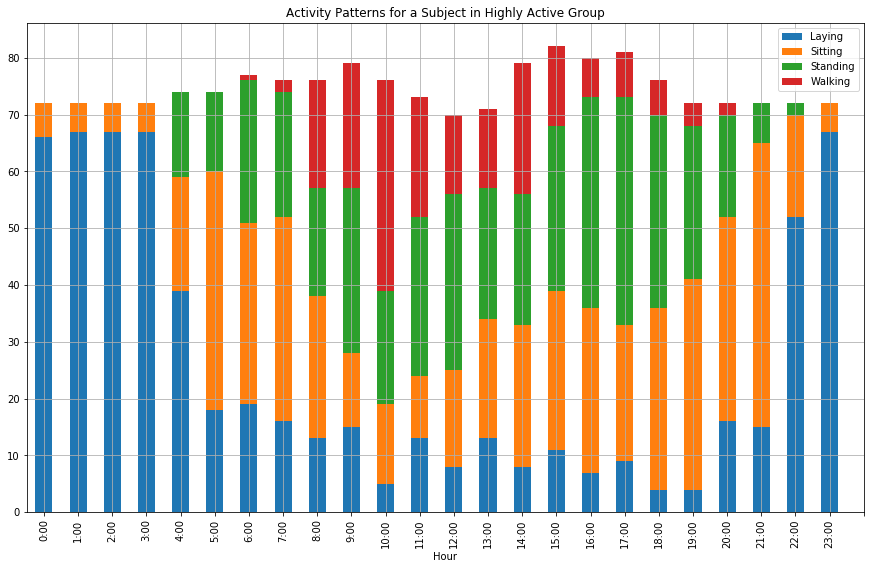

In [314]:
act_groups.unstack()['Steps'].plot(kind = "bar", stacked = True)
plt.xticks(np.arange(25), ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', \
                          '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', \
                          '21:00', '22:00', '23:00'])
plt.legend(loc="best")
plt.title("Activity Patterns for a Subject in Highly Active Group")
plt.grid()